In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from collections import Counter

import scipy as sp
import scipy.io
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from kdtree import KDTree

In [23]:
INT2LABEL = np.array(list('ABCDEFGHIJ'))

data = sp.io.loadmat("notMNIST_small.mat")

images = data['images'].transpose(2, 0, 1)
samples = (2 * images.reshape(-1, 784) - 255.0) / 255.0

n_components = 25
samples = TruncatedSVD(n_components).fit_transform(samples)

labels = data['labels'].astype(int)
labels = INT2LABEL[labels]

trnI, devI, trnX, devX, trnY, devY = train_test_split(images, samples, labels, test_size=0.1)
allX = np.concatenate([trnX, devX])
allY = np.concatenate([trnY, devY])
maskY = allY.copy()
maskY[trnY.size:] = 'NA'

In [32]:
tree = KDTree(allX, maskY)

Actual point has label H


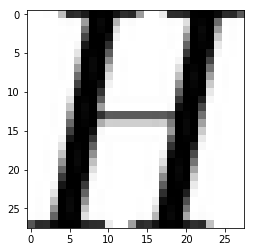

N 	 eta=0.909 	 delta=1.000 	 k=1
H 	 eta=0.409 	 delta=0.707 	 k=2
N 	 eta=0.576 	 delta=0.577 	 k=3
H 	 eta=0.659 	 delta=0.354 	 k=8
single tree predicted H


In [35]:
idx = np.random.randint(devY.size)
im, x, y = devI[idx], devX[idx], devY[idx]
print('Actual point has label %s' % y)
plt.imshow(im, cmap='Greys')
plt.show()

print('single tree predicted %s' % tree.get_pred(x, verbose=True))

In [6]:
def evaluate_rule(rule):
    correct = [rule(x) == y for x, y in zip(devX, devY)]
    return np.array(correct).mean()

## Accuracy of single tree

In [46]:
tree = KDTree(allX, maskY)

In [47]:
rule = lambda x: tree.get_pred(x, conf=1.0)
acc = evaluate_rule(rule)
print('accuracy of single atree is %.4f' % acc)

accuracy of single atree is 0.6391


## Ensemble / adaptive-forest

In [28]:
trees = [KDTree(allX, maskY) for _ in range(100)]

In [29]:
def rule(x):
    # simple predict-plurality rule for ensemble
    preds = [tree.get_pred(x, conf=1.0) for tree in trees]
    return Counter(preds).most_common(1)[0][0]

acc = evaluate_rule(rule)
print('accuracy of a-forest is %.4f' % acc)

accuracy of a-forest is 0.8841
